## ACT DR6-like bias



In ACT DR6 lensing (https://arxiv.org/abs/2304.05202, https://arxiv.org/abs/2304.05203), one of the ways we demonstrated robustness to foregrounds
was by running our pipeline on a couple of microwave-sky simulations, as described in MacCrann et al. 2023 (https://arxiv.org/abs/2304.05196). 
Here we get these biases for one of these simulations, websky (https://arxiv.org/abs/2001.08787).

We
- Read in foreground-only alms
- Read in total noise curves for filtering
- Read in a profile to use for profile-hardening (following https://arxiv.org/abs/2007.04325)
- Setup lensing reconstruction using `setup_recon`
- Calculate ACT DR6-like foreground biases using `get_bias_terms`


In [1]:
import os
os.environ["DISABLE_MPI"]="true"
from fgbias import setup_recon, get_bias_terms, get_cl_smooth,dummy_teb, ClBinner
from falafel import utils as futils, qe
import numpy as np
from orphics import maps
import healpy as hp
from pixell import curvedsky, enmap
import matplotlib.pyplot as plt
import healpy as hp

We use websky alms that have been processed in various ways to have similar residual foreground levels as the ACT DR6 data - see section 4.2 of MacCrann et al. 2023. These are stored at nersc. 

Read that in here...

In [2]:
fg_alm = hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4/prep_map/cmb_orig/fg_nonoise_alms_freqcoadd.fits")

Now setup the reconstruction tools. 

We need to specify a few parameters:
    - $l_{min}$ and $l_{max}$ for the alms going into the reconstruction
    - Total noise level for filters, based on ACT survey simulations, again we just read that in from files here.

This is the info required to specify the filtering of the CMB in the quadratic estimator. 

In [3]:
lmin=600
lmax=3000
mlmax=4000

cltot_file = "/global/cfs/projectdirs/act/data/maccrann/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4/prep_map/cmb_orig/Cltot_data.npy"
cltot_data = np.load(cltot_file)

#use falafel to get theory Cls 
#pass it a dictionary of noise Cls 
nells = {"TT" : cltot_data["Nltt_freqcoadd"][:mlmax+1], 
         "EE" : cltot_data["Nlee_freqcoadd"][:mlmax+1],
         "BB" : cltot_data["Nlbb_freqcoadd"][:mlmax+1]}
ucls,tcls = futils.get_theory_dicts(grad=True, 
                                    nells=nells,
                                    lmax=mlmax)

Finally, we're going to read in a tSZ power spectrum, also estimated from websky, to use as the "profile" in the 
profile-hardening method

In [4]:
profile = np.loadtxt("tsz_profile5000.txt")

Now call `setup_recon` to setup the lensing reconstruction stuff. We also need to specify what pixelsation our quadriatic estimator
is going to use. This shouldn't matter much. 

In [5]:
shape, wcs = enmap.fullsky_geometry(res=np.radians(1. / 60.0))
px_car = qe.pixelization(shape, wcs) #the pixelisation to use for the (real-space) quadratic estimator (shouldn't affect the result...much).

recon_stuff = setup_recon(px_car, lmin, lmax, mlmax, ucls,
                tcls, do_prh=True,
                profile=profile)

use new TT
 Response (TT)
use new TT


We need to read in a few more things though to estimate the foreground biases:
- True lensing potential alms (use this to calculate primary bispectrum)
- Two versions of the same unlensed cmb realization, one lensed by the true lensing potential,
one lensed by some different lensing potential.

In [6]:
#from websky
kappa_alm = futils.change_alm_lmax(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/kappa_alm_lmax6000.fits"),
    mlmax)
Ls = np.arange(mlmax+1)
phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )

#cmb lensed by true kappa
cmb_alm = dummy_teb(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/lensed_cmb/lensed_cmb_alm_websky_cmb1999_lmax6000.fits"),
)

#same cmb lensed by a different kappa
cmbp_alm = futils.get_cmb_alm(1999,0)

/tmp/ipykernel_1822689/3072968097.py:6: RuntimeWarning: divide by zero encountered in divide
  phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )


And we're ready to estimate the foreground biases using `get_bias_terms`. This will take about 12 minutes. Sorry. 

In [7]:
from timeit import default_timer as timer
import datetime

start=timer()
bias_stuff = get_bias_terms(fg_alm, recon_stuff, 
                   phi_alm, cmb_alm, cmbp_alm,
                   ests=["qe","prh"], comm=None)
end=timer()
print("took %s to get bias terms"%datetime.timedelta(seconds=end-start))

getting biases for est: qe
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_qe at 0x7f508323bf40>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

getting biases for est: prh
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_prh at 0x7f5083054040>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

use new TT
 Response (TT)
returning outputs
took 0:12:15.896912 to get bias terms


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:312: RuntimeWarning: invalid value encountered in divide
  N0 = norm_lens[i]**2/norm_fg[i]
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:313: RuntimeWarning: invalid value encountered in divide
  N0_s = norm_prof**2/norm_src_fg


/tmp/ipykernel_1822689/942134204.py:7: RuntimeWarning: invalid value encountered in divide
  cl_phiphi_theory = ucls["kk"] / (Ls * (Ls+1) / 2)**2 #get theory to compare to


Text(0.5, 1.0, 'DR6-like biases from websky')

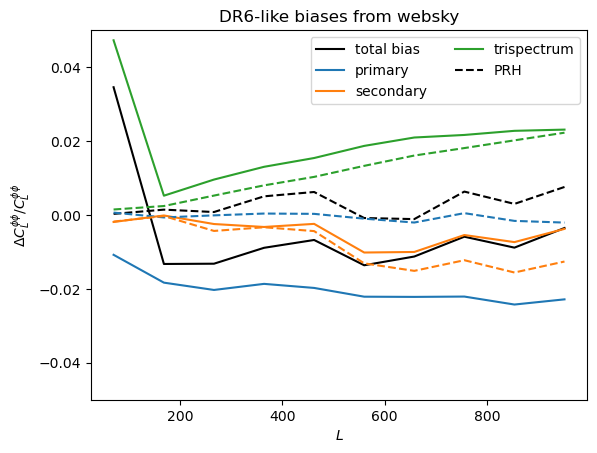

In [12]:
fig,ax=plt.subplots()

#function for binning Cl
binner = ClBinner(lmin=20, lmax=1000, nbin=10)

#get true cl_phi_phi to compare biases to
cl_phiphi_theory = ucls["kk"] / (Ls * (Ls+1) / 2)**2 #get theory to compare to
cl_phiphi_binned = binner(cl_phiphi_theory)

est, linestyle = "qe","-"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="k", label="total bias")
ax.plot(binner.bin_mids, binner(bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle, color="C0", label="primary")
ax.plot(binner.bin_mids, binner(bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle, color="C1", label="secondary")
ax.plot(binner.bin_mids, binner(bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle, color="C2", label="trispectrum")
#ax.plot(binner.bin_mids, binner(source_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4", label="trispectrum N0")

est, linestyle = "prh","--"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="k",)# label="total bias")
ax.plot(binner.bin_mids, binner(bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle,color="C0",) # label="primary")
ax.plot(binner.bin_mids, binner(bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle,color="C1",)# label="secondary")
ax.plot(binner.bin_mids, binner(bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle,color="C2",)# label="trispectrum")
#ax.plot(binner.bin_mids, binner(source_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4",)# label="trispectrum")
ax.plot([],[],'k--',label="PRH")

ax.set_ylim([-0.05,0.05])
#ax.set_yscale('symlog')
ax.legend(ncols=2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{\phi\phi} / C_L^{\phi\phi}$")
ax.set_title(r"DR6-like biases from websky")